# Importing all necessary libraries and our data

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer, WordNetLemmatizer
import pandas as pd
import re
import string
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np

In [3]:
df = pd.read_csv('/content/gdrive/MyDrive/TheSocialDilemma/TheSocialDilemma.csv')

In [4]:
df.head()

,user_name,user_location,user_description,user_created,user_followers,user_friends,user_favourites,user_verified,date,text,hashtags,source,is_retweet,Sentiment
0,Mari Smith,"San Diego, California",Premier Facebook Marketing Expert | Social Med...,2007-09-11 22:22:51,579942,288625,11610,False,2020-09-16 20:55:33,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,NaN,Twitter Web App,False,Neutral
1,Mari Smith,"San Diego, California",Premier Facebook Marketing Expert | Social Med...,2007-09-11 22:22:51,579942,288625,11610,False,2020-09-16 20:53:17,@musicmadmarc @SocialDilemma_ @netflix @Facebo...,NaN,Twitter Web App,False,Neutral
2,Varun Tyagi,"Goa, India",Indian | Tech Solution Artist & Hospitality Ex...,2009-09-06 10:36:01,257,204,475,False,2020-09-16 20:51:57,Go watch “The Social Dilemma” on Netflix!\n\nI...,NaN,Twitter for iPhone,False,Positive
3,Casey Conway,"Sydney, New South Wales",Head of Diversity & Inclusion @RugbyAU | It's ...,2012-12-28 21:45:06,11782,1033,12219,True,2020-09-16 20:51:46,I watched #TheSocialDilemma last night. I’m sc...,['TheSocialDilemma'],Twitter for iPhone,False,Negative
4,Charlotte Paul,Darlington,Instagram Charlottejyates,2012-05-28 20:43:08,278,387,5850,False,2020-09-16 20:51:11,The problem of me being on my phone most the t...,['TheSocialDilemma'],Twitter for iPhone,False,Positive


## Spliting our data into 2 equal parts

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(df['text'], df['Sentiment'], test_size=0.50)

In [6]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(10034,) (10034,) (10034,) (10034,)


### Removing neutral comments

In [7]:
X_train = X_train[(df.Sentiment == 'Positive') | (df.Sentiment == 'Negative')]
X_test = X_test[(df.Sentiment == 'Positive') | (df.Sentiment == 'Negative')]
y_train = y_train[(df.Sentiment == 'Positive') | (df.Sentiment == 'Negative')]
y_test = y_test[(df.Sentiment == 'Positive') | (df.Sentiment == 'Negative')]


### Cleaninig text

In [8]:
stop_words = stopwords.words("english")

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub("@\S+", " ", text)
    text = re.sub("https*\S+", " ", text)
    text = re.sub("#\S+", " ", text)
    text = re.sub("\d", " ", text)
    text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
    text = re.sub('\n', ' ', text)
    text = re.sub('\s{2,}',' ', text)
    text = ' '.join([word for word in text.split(' ') if word not in stop_words])
    return text

In [10]:
X_train = X_train.apply(lambda x:clean_text(x))
X_test = X_test.apply(lambda x:clean_text(x))

## Converting "Positive" and "Negative" into 1.0 and 0.0 for further calculations

In [11]:
def MakingLabel(text):
  if text == "Positive":
    return 1.0
  if text == "Negative":
    return 0.0

In [12]:
y_train = y_train.apply(lambda x:MakingLabel(x))
y_test = y_test.apply(lambda x:MakingLabel(x))

In [13]:
y_train[:20]

5543     1.0
16837    0.0
6779     1.0
14787    0.0
4629     1.0
622      1.0
8623     1.0
462      0.0
1939     1.0
17006    1.0
2991     1.0
15261    0.0
3281     0.0
6917     0.0
18424    0.0
5435     1.0
11200    1.0
116      1.0
16313    1.0
1155     1.0
Name: Sentiment, dtype: float64

## Making a dictionary of the whole text to create sequences

In [14]:
text = ''
for i in X_train:
    text += i + ' '
for i in X_test:
    text += i + ' '

In [15]:
def tokenization(text):
    tokens = word_tokenize(text)
    return tokens

In [16]:
def lemmatizer(text):
    lemm_text = [WordNetLemmatizer().lemmatize(word) for word in text]
    return lemm_text

In [17]:
dict_full = list(set(lemmatizer(tokenization(text))))

## Making sequences

In [18]:
def sequences(text):
    sequence = [dict_full.index(i) for i in lemmatizer(tokenization(text))]
    return sequence

In [19]:
X_train = X_train.apply(lambda x:sequences(x))
X_test = X_test.apply(lambda x:sequences(x))

## Vectorizing sequences


In [20]:
def vectorize_sequences(sequences, dimension=11000):
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        for j in sequence:
            results[i, j] = 1.
    return results

In [21]:
X_train = vectorize_sequences(X_train)
X_test = vectorize_sequences(X_test)

In [22]:
y_train = np.asarray(y_train).astype("float32")
y_test = np.asarray(y_test).astype("float32")

## Making our model

In [23]:
model = keras.Sequential([
    layers.Dense(32, activation="relu"),
    layers.Dense(1, activation="sigmoid")
])

model.compile(optimizer="rmsprop",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history = model.fit(X_train,
                    y_train,
                    epochs=10,
                    batch_size=512,
                    validation_split=0.2,
                    shuffle = True,
                    verbose = 2)

Epoch 1/10
11/11 - 1s - loss: 0.6510 - accuracy: 0.7159 - val_loss: 0.6160 - val_accuracy: 0.7368 - 1s/epoch - 119ms/step
Epoch 2/10
11/11 - 0s - loss: 0.5789 - accuracy: 0.7682 - val_loss: 0.5762 - val_accuracy: 0.7414 - 420ms/epoch - 38ms/step
Epoch 3/10
11/11 - 0s - loss: 0.5275 - accuracy: 0.7850 - val_loss: 0.5457 - val_accuracy: 0.7559 - 402ms/epoch - 37ms/step
Epoch 4/10
11/11 - 0s - loss: 0.4828 - accuracy: 0.8056 - val_loss: 0.5198 - val_accuracy: 0.7696 - 408ms/epoch - 37ms/step
Epoch 5/10
11/11 - 0s - loss: 0.4427 - accuracy: 0.8313 - val_loss: 0.4974 - val_accuracy: 0.7803 - 393ms/epoch - 36ms/step
Epoch 6/10
11/11 - 0s - loss: 0.4066 - accuracy: 0.8531 - val_loss: 0.4778 - val_accuracy: 0.7979 - 436ms/epoch - 40ms/step
Epoch 7/10
11/11 - 0s - loss: 0.3741 - accuracy: 0.8701 - val_loss: 0.4610 - val_accuracy: 0.8009 - 426ms/epoch - 39ms/step
Epoch 8/10
11/11 - 0s - loss: 0.3442 - accuracy: 0.8874 - val_loss: 0.4456 - val_accuracy: 0.8078 - 438ms/epoch - 40ms/step
Epoch 9/10

In [24]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                352032    
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 352,065
Trainable params: 352,065
Non-trainable params: 0
_________________________________________________________________
None


In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

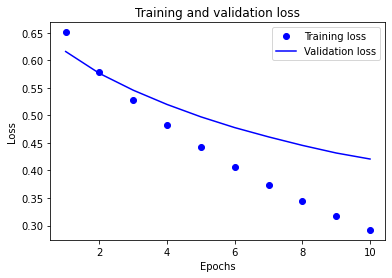

In [26]:
history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label="Training loss")
plt.plot(epochs, val_loss_values, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [27]:
score = model.evaluate(X_test, y_test, verbose=0) 
print('Test score:', score[0]) 
print('Test accuracy:', score[1])

Test score: 0.3938741087913513
Test accuracy: 0.836547315120697
